# Photometric Repeatability using `MultiMatch` and `GroupView`

This notebook uses the `MultiMatch` and `GroupView` classes from `afw.table`'s `multiMatch.py`.  It is intended to be run on `lsst-dev.ncsa.illinois.edu`, on an HSC output repository produced at the end of the S15 cycle (where it was used to measure key performance metrics related to photometric repeatability).  It can be adapted to run on other datasets by modifying the repository path and data IDs below.

In [1]:
import numpy
from lsst.afw.table import MultiMatch, SimpleRecord, GroupView
import lsst.daf.persistence

In [2]:
butler = lsst.daf.persistence.Butler("/raid/lauren/rerun/LSST/STRIPE82L/v2/")
dataset = "transformed_src"

In [3]:
schema = butler.get(dataset + "_schema", immediate=True).schema

Create an object that can match multiple catalogs with the same schema

In [4]:
m = MultiMatch(schema, dict(visit=int), RecordClass=SimpleRecord)

Create a list of `DataRef`s for all CCDs images to be included in the plot.

In [5]:
dataRefs = [dataRef for dataRef in butler.subset(dataset, field="STRIPE82L", filter="HSC-I")
            if dataRef.datasetExists(dataset)]

Create visit catalogs by merging those from constituent CCDs.  We also convert from `BaseCatalog` to `SimpleCatalog`, but in the future we'll probably want to have the source transformation tasks generate `SimpleCatalog`s (or `SourceCatalog`s) directly.

In [6]:
byVisit = {}
for dataRef in dataRefs:
    catalog = byVisit.setdefault(dataRef.dataId["visit"], SimpleRecord.Catalog(schema))
    catalog.extend(dataRef.get(dataset, immediate=True), deep=True)

Loop over visits, adding them to the match.

In [7]:
for visit, catalog in byVisit.iteritems():
    m.add(catalog, dict(visit=visit))

Complete the match, returning a catalog that includes all matched sources with object IDs that can be used to group them.

In [8]:
matchCat = m.finish()

Create a mapping object that allows the matches to be manipulated as a mapping of object ID to catalog of sources.

In [9]:
allMatches = GroupView.build(matchCat)

Filter down to matches with at least 2 sources and good flags

In [10]:
flagKeys = [allMatches.schema.find("base_PixelFlags_flag_%s" % flag).key
            for flag in ("saturated", "cr", "bad", "edge")]
nMatchesRequired = 2
def goodFilter(cat):
    if len(cat) < nMatchesRequired:
        return False
    for flagKey in flagKeys:
        if cat.get(flagKey).any():
            return False
    return True
goodMatches = allMatches.where(goodFilter)

In [11]:
psfMagKey = allMatches.schema.find("base_PsfFlux_mag").key
modelMagKey = allMatches.schema.find("base_GaussianFlux_mag").key

In [12]:
from matplotlib import pyplot
%matplotlib inline

Filter further to a limited range in magnitude and extendedness to select bright stars (plotted below).  The upturn at the bright end is due to the brighter-fatter effect on the sensors, but shouldn't matter for this test because it will affect all visits in approximately the same way (since they all have the same exposure time).

In [13]:
safeMinMag = 16.5
safeMaxMag = 18.0
safeMaxExtend = 0.02
def safeFilter(cat):
    psfMag = numpy.mean(cat.get(psfMagKey))
    modelMag = numpy.mean(cat.get(psfMagKey))
    extend = numpy.abs(psfMag - modelMag)
    return psfMag >= safeMinMag and modelMag <= safeMaxMag and extend < safeMaxExtend
safeMatches = goodMatches.where(safeFilter)

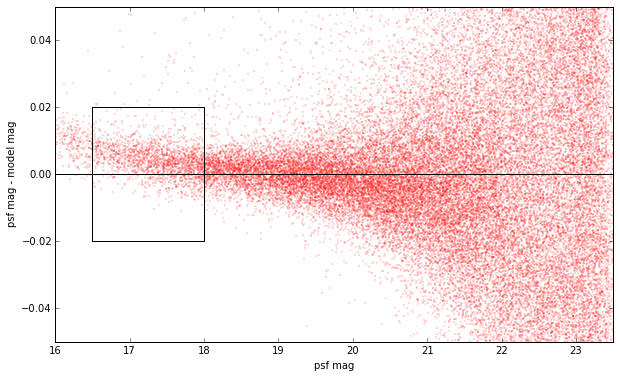

In [14]:
goodPsfMag = goodMatches.aggregate(numpy.mean, field=psfMagKey)
goodModelMag = goodMatches.aggregate(numpy.mean, field=modelMagKey)
fig = pyplot.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.axhline(0, color='k')
ax.scatter(goodModelMag, goodPsfMag - goodModelMag, c='r', s=4, linewidth=0, alpha=0.2)
ax.plot([safeMinMag, safeMaxMag, safeMaxMag, safeMinMag, safeMinMag],
        [-safeMaxExtend, -safeMaxExtend, safeMaxExtend, safeMaxExtend, -safeMaxExtend], 'k-')
ax.set_ylim(-0.05, 0.05)
ax.set_xlim(16, 23.5)
ax.set_ylabel("psf mag - model mag")
ax.set_xlabel("psf mag")

The SRD recommends computing repeatability from a histogram of magnitude differences for the same star measured on two visits (using a median over the diffs to reject outliers).  Since our dataset includes $N>2$ measurements for each star, we select a random pairs of visits for each star.

We also divide each difference by $\sqrt{2}$, because we want the RMS about the (unknown) mean magnitude, not the RMS difference, and convert from mags to mmag.

In [114]:
def getRandomDiff(array):
    # not the most efficient way to extract a pair, but it's the easiest to write
    copy = array.copy()
    numpy.random.shuffle(copy)
    return 1000*(copy[0] - copy[1])/(2**0.5)

We estimate the width of the histogram in two ways: using a simple RMS, and using the interquartile range (scaled by the IQR/RMS ratio for a Gaussian).  We do this for 50 different random realizations of the measurement pairs, to provide some estimate of the uncertainty on our RMS estimates due to the random shuffling (we could probably turn this into a more formal estimate somehow, but I'm not going to bother with that at the moment).

While the SRD specifies that we should just compute the RMS directly, we haven't limited our sample to nonvariable stars as carefully as the SRD specifies, so using a more robust estimator like IQR will allow us to reject some outliers.  It is also less sensitive some realistic sources of scatter the metric should include, however, such as bad zero points.

In [119]:
import scipy.stats

def computeWidths(diffs):
    rmsSigma = numpy.mean(diffs**2)**0.5
    iqrSigma = numpy.subtract.reduce(numpy.percentile(diffs, [75, 25])) / (scipy.stats.norm.ppf(0.75)*2)
    return rmsSigma, iqrSigma

rmsPA1 = []
iqrPA1 = []
for i in range(50):
    diffs = safeMatches.aggregate(getRandomDiff, field=psfMagKey)
    rmsSigma, iqrSigma = computeWidths(diffs)
    rmsPA1.append(rmsSigma)
    iqrPA1.append(iqrSigma)
rmsPA1 = numpy.array(rmsPA1)
iqrPA1 = numpy.array(iqrPA1)
print "PA1(RMS)=%4.2f±%4.2f" % (rmsPA1.mean(), rmsPA1.std())
print "PA1(IQR)=%4.2f±%4.2f" % (iqrPA1.mean(), iqrPA1.std())

PA1(RMS)=16.89±0.54
PA1(IQR)=15.46±0.21


To validate these width estimates, we can plot a single random realization (re-evaluate the cell or call the function again to get a new one).

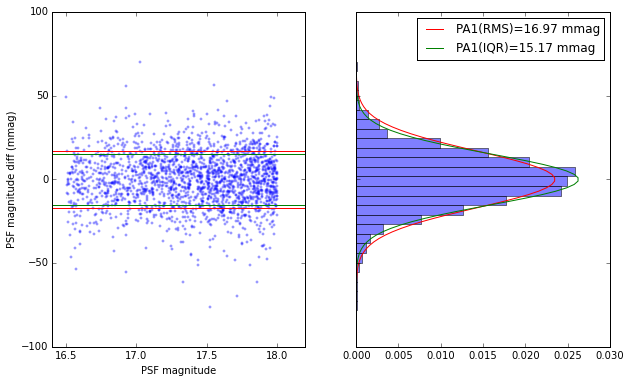

In [136]:
def plotPA1(gv):
    diffs = gv.aggregate(getRandomDiff, field=psfMagKey)
    means = gv.aggregate(numpy.mean, field=psfMagKey)
    rmsPA1, iqrPA1 = computeWidths(diffs)
    fig = pyplot.figure(figsize=(10,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(means, diffs, s=8, linewidth=0, alpha=0.4)
    ax1.axhline(rmsPA1, color='r')
    ax1.axhline(-rmsPA1, color='r')
    ax1.axhline(iqrPA1, color='g')
    ax1.axhline(-iqrPA1, color='g')
    ax2 = fig.add_subplot(1,2,2, sharey=ax1)
    ax2.hist(diffs, bins=50, orientation='horizontal', normed=True, alpha=0.5)
    yv = numpy.linspace(-100, 100, 100)
    ax2.plot(scipy.stats.norm.pdf(yv, scale=rmsPA1), yv, 'r-', label="PA1(RMS)=%4.2f mmag" % rmsPA1)
    ax2.plot(scipy.stats.norm.pdf(yv, scale=iqrPA1), yv, 'g-', label="PA1(IQR)=%4.2f mmag" % iqrPA1)
    ax2.set_ylim(-100, 100)
    ax2.legend()
    ax1.set_ylabel(u"PSF magnitude diff (mmag)")
    ax1.set_xlabel("PSF magnitude")
    for label in ax2.get_yticklabels(): label.set_visible(False)
plotPA1(safeMatches)

The PF1/PA2 puts a limit on the fraction of outliers in the above plot.  Below, we compute the values of PA2 for the minimum, design, and stretch specification values of PF1 in the SRD.

In [135]:
def printPA2(gv):
    diffs = gv.aggregate(getRandomDiff, field=psfMagKey)
    minPA2, designPA2, stretchPA2 = numpy.percentile(numpy.abs(diffs), [80, 90, 95])
    print "minimum: PF1=20%% of diffs more than %4.2f mmag (target is 15)" % minPA2
    print "design: PF1=10%% of diffs more than %4.2f mmag (target is 15)" % designPA2
    print "stretch: PF1=5%% of diffs more than %4.2f mmag (target is 10)" % stretchPA2
printPA2(safeMatches)

minimum: PF1=20% of diffs more than 19.56 mmag (target is 15)
design: PF1=10% of diffs more than 25.31 mmag (target is 15)
stretch: PF1=5% of diffs more than 32.76 mmag (target is 10)
